In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-lightning pandas xarray torchist xskillscore pyyaml zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [3]:
!pip install pywake

  Preparing metadata (setup.py) ... done
  Created wheel for pywake: filename=pywake-0.1.3-py3-none-any.whl size=16569 sha256=cebfae4ff7cce4ab543b7cb185b6af91866e827c34a54ef5b3ba929153b4679d
  Stored in directory: /root/.cache/pip/wheels/56/70/f0/a68960298fd741d917de3a10a98d17463a981afe0087a22e75
Successfully built pywake


In [4]:
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to /tmp/pip-req-build-d3eytvte
  Running command git clone --filter=blob:none --quiet https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git /tmp/pip-req-build-d3eytvte
  Resolved https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to commit 18d9a666858a205641c461386f31ae558cb5b155
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.0 MB/s eta 0:00:00
  Created wheel for py_wake: filename=py_wake-2.6.9-py3-none-any.whl size=19890101 sha256=21575f57beeac43276312f804d8e86c10b9a61d17261e8e357bb4360c414de04
  Stored in directory: /tmp/pip-ephem-wheel-cache-zlmo92cm/wheels/76/2f/75/c056f102fb42126f415398d5817b64ad9edbe27227039b02b3
Successfully built py_wake


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/chaosbench')  # adjust this if your ChaosBench is in a different location

In [6]:
import torch
import yaml
from models.model import S2SBenchmarkModel
from dataset import CSV_ERA5_Dataset
import config

# Load YAML config (adjust path if needed)
config_filepath = '/content/drive/MyDrive/chaosbench/configs/fno_pinn.yaml'
with open(config_filepath, 'r') as file:
    config_yaml = yaml.safe_load(file)

model_args = config_yaml['model_args']
data_args = config_yaml['data_args']

# ✅ Load model directly from checkpoint (NO instance creation beforehand)
ckpt_path = '/content/drive/MyDrive/ChaosBench/checkpoints/best_model.ckpt'
model = S2SBenchmarkModel.load_from_checkpoint(
    ckpt_path,
    model_args=model_args,
    data_args=data_args
)
model.eval()

# Dataset and dataloader
train_dataset = CSV_ERA5_Dataset(
    years=data_args['train_years'],
    variables=config.PARAMS,
    pressure_levels=config.PRESSURE_LEVELS,
    is_normalized=True
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

# Prediction loop
predictions = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
with torch.no_grad():
    for _, inputs, _ in train_loader:  # triple unpacking assuming your dataset returns (timestamp, inputs, targets)
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu())

predictions = torch.cat(predictions, dim=0)  # Shape: (timesteps, channels, H, W)


In [7]:
# print("Predictions shape:", predictions.shape)  # Should be (timesteps, channels, H, W)
# print("First timestep, u10 sample:")
# print(predictions[0, 0])  # u10 for timestep 0

# print("First timestep, v10 sample:")
# print(predictions[0, 1])  # v10 for timestep 0


Predictions shape: torch.Size([685, 48, 9, 8])
First timestep, u10 sample:
tensor([[-0.1695,  0.1664,  0.1954,  0.0967,  0.0755,  0.1695,  0.1065, -0.1978],
        [-0.3321, -0.4380, -0.6218, -0.5668, -0.5011, -0.4586, -0.4237, -0.3439],
        [-0.3448, -0.2220,  0.2376,  0.1070,  0.0638,  0.1686,  0.2318, -0.1739],
        [-0.1673,  0.0755, -0.1328, -0.3026, -0.2455, -0.2446, -0.2930, -0.2809],
        [-0.0626, -0.0962, -0.1516, -0.0469,  0.0532,  0.1875, -0.0943,  0.1635],
        [-0.0397,  0.1522,  0.1777,  0.1003,  0.2918,  0.2805, -0.1233,  0.0798],
        [ 0.0933,  0.2026,  0.2231,  0.1571,  0.0391, -0.1321,  0.0601, -0.2170],
        [-0.4544, -0.3076, -0.3839, -0.4340, -0.5165, -0.3943, -0.4588, -0.4509],
        [-0.2665, -0.0796, -0.1367, -0.1617, -0.1718, -0.1400, -0.1089, -0.3598]])
First timestep, v10 sample:
tensor([[0.4303, 0.1576, 0.0126, 0.0500, 0.1207, 0.1781, 0.1965, 0.2751],
        [0.6052, 0.5946, 0.5538, 0.5516, 0.6054, 0.5967, 0.4511, 0.4663],
        [0

In [7]:
import xarray as xr
import numpy as np

# ✅ Load climatology dataset from your Google Drive
# climatology_path = '/content/drive/MyDrive/climatology/climatology_era5.zarr'
# climatology = xr.open_zarr(climatology_path)

# # 🔍 Extract variables
# mean = climatology['mean'].values       # shape: (num_params, H, W)
# sigma = climatology['sigma'].values     # same shape
# params = climatology['param'].values    # shape: (num_params,)

# print(f"Params in climatology: {params}")

# # ✅ Find indices for u10 and v10
# u10_idx = np.where(params == 'u-10')[0][0]
# v10_idx = np.where(params == 'v-10')[0][0]

# print(f"u10 index: {u10_idx}, v10 index: {v10_idx}")

# # Extract only u10 and v10 mean/sigma
# mean_u10 = mean[u10_idx]    # shape: (H, W)
# mean_v10 = mean[v10_idx]
# sigma_u10 = sigma[u10_idx]
# sigma_v10 = sigma[v10_idx]

# # 🟢 Sanity check
# print("u10 mean stats:", np.mean(mean_u10), "sigma:", np.mean(sigma_u10))
# print("v10 mean stats:", np.mean(mean_v10), "sigma:", np.mean(sigma_v10))

climatology = xr.open_zarr('/content/drive/MyDrive/climatology/climatology_era5.zarr')
params = climatology['param'].values
u10_idx, v10_idx = np.where(params == 'u-10')[0][0], np.where(params == 'v-10')[0][0]

mean_u10 = climatology['mean'].values[u10_idx]
sigma_u10 = climatology['sigma'].values[u10_idx]
mean_v10 = climatology['mean'].values[v10_idx]
sigma_v10 = climatology['sigma'].values[v10_idx]

u10 = predictions[:, 0] * sigma_u10 + mean_u10
v10 = predictions[:, 1] * sigma_v10 + mean_v10

wind_speed = torch.sqrt(u10 ** 2 + v10 ** 2)
wind_direction = torch.atan2(v10, u10) * (180 / np.pi) % 360

In [8]:
# # Assuming you already have predictions tensor (e.g. from your model)
# # Shape: (timesteps, channels=2, H, W) where channels=[u10, v10]
# u10_norm = predictions[:, 0, :, :]  # Normalized u10
# v10_norm = predictions[:, 1, :, :]  # Normalized v10

# # Broadcast mean and sigma to match prediction shape
# mean_u10_t = torch.tensor(mean_u10, dtype=torch.float32).unsqueeze(0)
# sigma_u10_t = torch.tensor(sigma_u10, dtype=torch.float32).unsqueeze(0)
# mean_v10_t = torch.tensor(mean_v10, dtype=torch.float32).unsqueeze(0)
# sigma_v10_t = torch.tensor(sigma_v10, dtype=torch.float32).unsqueeze(0)

# # Denormalize
# u10 = u10_norm * sigma_u10_t + mean_u10_t
# v10 = v10_norm * sigma_v10_t + mean_v10_t

# # Calculate wind speed & direction
# wind_speed = torch.sqrt(u10 ** 2 + v10 ** 2)
# wind_direction = torch.atan2(v10, u10) * (180 / np.pi) % 360

print(f"Wind speed shape: {wind_speed.shape}")
print(f"Wind direction shape: {wind_direction.shape}")
print("First denorm wind speed sample:\n", wind_speed[0])
print("First denorm wind direction sample:\n", wind_direction[0])

Wind speed shape: torch.Size([685, 9, 8])
Wind direction shape: torch.Size([685, 9, 8])
First denorm wind speed sample:
 tensor([[ 4.6443,  9.1853,  9.7698,  7.2668,  6.8281,  9.3072,  7.7877,  2.9711],
        [ 7.4855,  9.0543, 12.6082, 11.3761, 10.3336,  9.4518,  7.7565,  6.4191],
        [ 8.7445, 11.1225, 13.8049, 12.5495, 11.7097, 13.4972, 15.2442,  7.7680],
        [ 4.1191,  8.8662,  8.1908,  7.9984,  3.7772,  3.6531,  5.5571,  6.6439],
        [ 4.7216,  4.9642,  3.4631,  7.1588, 10.3762, 13.0350, 11.5958,  9.3679],
        [ 6.7960,  9.6011, 10.1180,  8.4251, 12.9989, 12.4994,  6.5697,  7.2783],
        [10.3896, 11.3071, 12.5357, 11.2584,  8.7256,  6.2787,  6.7556,  2.9010],
        [ 8.5911,  4.8812,  6.0099,  7.0105,  9.0543,  6.1120,  8.3750,  7.1202],
        [ 5.7289,  8.6172,  7.3226,  7.3532,  7.0378,  7.3631,  7.6929,  8.0404]])
First denorm wind direction sample:
 tensor([[ 84.5390,  10.6504,   0.8352,   4.2863,  10.9912,  11.8903,  15.7549,
          95.4566],
    

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from py_wake.examples.data.hornsrev1 import V80
# from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
# from py_wake.superposition_models import SquaredSum
# from py_wake.site import UniformSite

# # Inject your denormalized wind predictions directly
# predicted_ws = np.mean(wind_speed[0].numpy())
# predicted_wd = np.mean(wind_direction[0].numpy())

# # predicted_ws = wind_speed[0]
# # predicted_wd = wind_direction[0]

# # Clyde Farm-like cluster layout with 150 turbines
# n_turbines = 150
# x, y = np.random.multivariate_normal([0, 0], [[400**2, 0], [0, 400**2]], n_turbines).T

# # Uniform site with dynamic wind input
# site = UniformSite(p_wd=[1], ti=0.1)
# site.default_wd = np.array([predicted_wd])
# site.default_ws = np.array([predicted_ws])

# # Setup turbine and wake model
# wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())
# sim_res = wake_model(x, y)

# fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# # Wake plot
# sim_res.flow_map().plot_wake_map(ax=axs[0])
# axs[0].scatter(x, y, color='black')
# axs[0].set_title("Clyde Farm (Cluster Layout with Predicted Wind)")

# # Power output plot
# power_output = sim_res.Power.values.flatten()
# scatter = axs[1].scatter(x, y, c=power_output, cmap='Blues', s=50)
# axs[1].set_title("Power Output (Clyde Farm)")
# fig.colorbar(scatter, ax=axs[1], label='Power (MW)')

# plt.tight_layout()
# plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# from py_wake.examples.data.hornsrev1 import V80
# from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
# from py_wake.superposition_models import SquaredSum
# from py_wake.site import UniformSite

# # Inject your denormalized wind predictions directly
# predicted_ws = np.mean(wind_speed[0].numpy())
# predicted_wd = np.mean(wind_direction[0].numpy())

# # Clyde Farm-like cluster layout with 150 turbines
# n_turbines = 150
# x, y = np.random.multivariate_normal([0, 0], [[400**2, 0], [0, 400**2]], n_turbines).T

# # Uniform site with dynamic wind input
# site = UniformSite(p_wd=[1], ti=0.1)
# site.default_wd = np.array([predicted_wd])
# site.default_ws = np.array([predicted_ws])

# # Apply random yaw angles for each turbine
# yaw_angles = np.random.uniform(-30, 30, n_turbines)

# # Setup turbine and wake model
# wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())
# sim_res = wake_model(x, y, yaw=yaw_angles)

# fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# # Wake plot
# sim_res.flow_map().plot_wake_map(ax=axs[0])
# axs[0].scatter(x, y, color='black')
# axs[0].set_title("Clyde Farm (Cluster Layout with Random Yaw)")

# # Power output plot
# power_output = sim_res.Power.values.flatten()
# scatter = axs[1].scatter(x, y, c=power_output, cmap='Blues', s=50)
# axs[1].set_title("Power Output (Random Yaw)")
# fig.colorbar(scatter, ax=axs[1], label='Power (MW)')

# plt.tight_layout()
# plt.show()

# # Total power calculation
# total_power_MW = np.sum(sim_res.Power.values) / 1e6
# print(f"Total Power Output (with random yaw): {total_power_MW:.2f} MW")

# import numpy as np
# import matplotlib.pyplot as plt
# from py_wake.examples.data.hornsrev1 import V80
# from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
# from py_wake.superposition_models import SquaredSum
# from py_wake.site import UniformSite

# # --- Your FNO predictions ---
# # predicted_ws = np.mean(wind_speed[0].numpy())
# # predicted_wd = np.mean(wind_direction[0].numpy())
# all_timesteps_ws = []
# all_timesteps_wd = []

# for t in range(45):  # Assuming 45 timesteps
#     ws = wind_speed[t].numpy()  # shape: (H, W)
#     wd = wind_direction[t].numpy()  # shape: (H, W)
#     all_timesteps_ws.append(ws)
#     all_timesteps_wd.append(wd)

# all_timesteps_ws = np.stack(all_timesteps_ws)  # shape: (45, H, W)
# all_timesteps_wd = np.stack(all_timesteps_wd)  # shape: (45, H, W)

# # --- Horns Rev 1 Layout (10x8 grid) ---
# spacing = 560
# nx, ny = 10, 8
# x = np.arange(nx) * spacing
# y = np.arange(ny) * spacing
# xx, yy = np.meshgrid(x, y)
# turbine_x = xx.flatten()
# turbine_y = yy.flatten()
# n_turbines = turbine_x.size

# # --- Random yaw angles ---
# yaw_angles = np.random.uniform(-30, 30, n_turbines)  # degrees

# # --- Uniform site ---
# site = UniformSite(p_wd=[1], ti=0.1)
# site.default_ws = np.array([predicted_ws])
# site.default_wd = np.array([predicted_wd])

# # --- Wake model simulation ---
# wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())
# sim_res = wake_model(turbine_x, turbine_y, yaw=yaw_angles)

# fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# # --- Wake map ---
# sim_res.flow_map().plot_wake_map(ax=axs[0])
# axs[0].scatter(turbine_x, turbine_y, color='black', label='Turbines')

# # --- Black yaw lines ---
# line_length = 300  # Adjust length here
# for i in range(n_turbines):
#     yaw_rad = np.deg2rad(yaw_angles[i])
#     dx = line_length * np.cos(yaw_rad)
#     dy = line_length * np.sin(yaw_rad)
#     axs[0].plot([turbine_x[i] - dx/2, turbine_x[i] + dx/2],
#                 [turbine_y[i] - dy/2, turbine_y[i] + dy/2], color='black')

# axs[0].set_title("Horns Rev 1 (Black Yaw Lines + FNO Wind)")
# axs[0].legend()

# # --- Power output ---
# power_output = sim_res.Power.values.flatten()
# scatter = axs[1].scatter(turbine_x, turbine_y, c=power_output, cmap='Blues', s=50)
# axs[1].set_title("Power Output (Random Yaw)")
# fig.colorbar(scatter, ax=axs[1], label='Power (MW)')

# plt.tight_layout()
# plt.show()






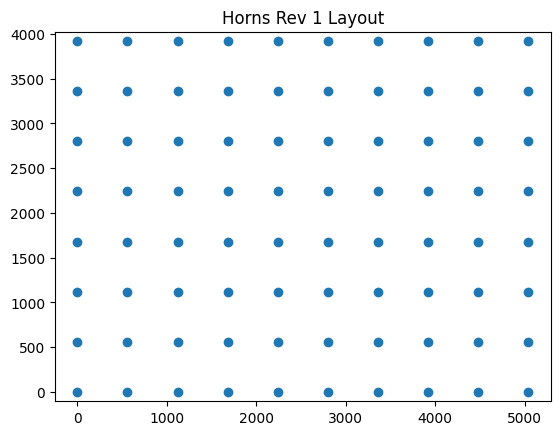

In [11]:
import matplotlib.pyplot as plt

nx, ny, spacing = 10, 8, 560
x = np.arange(nx) * spacing
y = np.arange(ny) * spacing
xx, yy = np.meshgrid(x, y)
turbine_x = torch.tensor(xx.flatten(), dtype=torch.float32)
turbine_y = torch.tensor(yy.flatten(), dtype=torch.float32)
num_turbines = len(turbine_x)

plt.scatter(turbine_x, turbine_y)
plt.axis('equal')
plt.title("Horns Rev 1 Layout")
plt.show()

🆕 Generated and saved Horns Rev 1 layout.


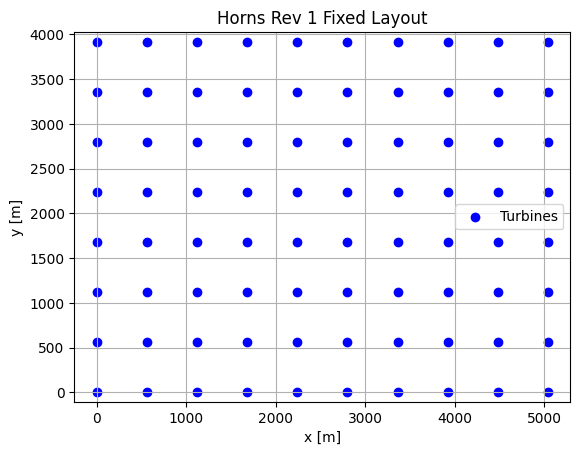

In [10]:
# import numpy as np

# # ---------- CONFIG ----------
# nx, ny = 10, 8     # Horns Rev 1 grid: 10 turbines in x, 8 in y
# spacing = 560      # Rotor diameters spacing (m)
# layout_file = 'horns_rev_layout.npz'

# # ---------- GENERATE LAYOUT (ONLY ONCE) ----------
# try:
#     # Load existing layout
#     layout = np.load(layout_file)
#     turbine_x = layout['turbine_x']
#     turbine_y = layout['turbine_y']
#     print("✅ Loaded fixed Horns Rev 1 layout.")
# except FileNotFoundError:
#     # Create regular grid layout
#     x = np.arange(nx) * spacing
#     y = np.arange(ny) * spacing
#     xx, yy = np.meshgrid(x, y)
#     turbine_x = xx.flatten()
#     turbine_y = yy.flatten()
#     # Save layout
#     np.savez(layout_file, turbine_x=turbine_x, turbine_y=turbine_y)
#     print("🆕 Generated and saved Horns Rev 1 layout.")

# # ---------- PREVIEW LAYOUT ----------
# import matplotlib.pyplot as plt
# plt.scatter(turbine_x, turbine_y, marker='o', color='blue', label='Turbines')
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# plt.axis('equal')
# plt.legend()
# plt.title("Horns Rev 1 Fixed Layout")
# plt.grid(True)
# plt.show()


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.hornsrev1 import V80
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.superposition_models import SquaredSum
from py_wake.site import UniformSite
from tqdm import tqdm

site = UniformSite(p_wd=[1], ti=0.1)
wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())

features_list, power_list = [], []
for _ in tqdm(range(5000)):
    ws, wd = np.random.uniform(5, 14), np.random.uniform(0, 360)
    yaw = np.random.uniform(-30, 30, num_turbines)
    site.default_wd, site.default_ws = np.array([wd]), np.array([ws])
    sim_res = wake_model(turbine_x.numpy(), turbine_y.numpy(), yaw=yaw)
    total_power = np.sum(sim_res.Power.values) / 1e6

    yaw_t = torch.tensor(yaw, dtype=torch.float32)
    ws_t = torch.full((num_turbines,), ws)
    wd_t = torch.full((num_turbines,), wd)
    feat = torch.stack([yaw_t, ws_t, wd_t, turbine_x, turbine_y], dim=1)

    features_list.append(feat)
    power_list.append(torch.tensor(total_power, dtype=torch.float32))

torch.save({'features': features_list, 'powers': power_list}, 'surrogate_dataset.pt')

100%|██████████| 5000/5000 [03:49<00:00, 21.82it/s]


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --- Surrogate Model ---
class PowerSurrogateNet(nn.Module):
    def __init__(self, num_turbines, hidden_dim=128):
        super(PowerSurrogateNet, self).__init__()
        self.fc1 = nn.Linear(num_turbines * 5, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Predict total power

    def forward(self, yaw, ws, wd, turbine_x, turbine_y):
        """
        yaw: [batch_size, num_turbines]
        ws:  [batch_size, 1]
        wd:  [batch_size, 1]
        turbine_x, turbine_y: [num_turbines] (constants)
        """
        batch_size, num_turbines = yaw.shape

        # Repeat turbine layout for batch
        x = turbine_x.unsqueeze(0).repeat(batch_size, 1).to(yaw.device)
        y = turbine_y.unsqueeze(0).repeat(batch_size, 1).to(yaw.device)

        ws_exp = ws.repeat(1, num_turbines)
        wd_exp = wd.repeat(1, num_turbines)

        # Stack all turbine-level inputs
        features = torch.stack([yaw, ws_exp, wd_exp, x, y], dim=2)  # [batch_size, num_turbines, 5]
        features = features.view(batch_size, -1)

        h = F.relu(self.fc1(features))
        h = F.relu(self.fc2(h))
        power = self.fc3(h)  # [batch_size, 1]
        return power.squeeze(1)


# --- Surrogate Dataset Loader ---
class SurrogateDataset(Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.features = data['features']
        self.powers = data['powers']

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.powers[idx]

# Load dataset
num_turbines = turbine_x.shape[0]
dataset = SurrogateDataset('surrogate_dataset.pt')
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model + Optimizer
surrogate = PowerSurrogateNet(num_turbines).to(device)
optimizer = torch.optim.Adam(surrogate.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# --- Training loop ---
for epoch in range(50):
    surrogate.train()
    total_loss = 0.0
    for feat, power in train_loader:
        feat, power = feat.to(device), power.to(device)

        # Split `feat`: shape [batch_size, num_turbines, 5]
        yaw = feat[:, :, 0]
        ws = feat[:, 0, 1].unsqueeze(1)  # single ws per sample
        wd = feat[:, 0, 2].unsqueeze(1)  # single wd per sample

        # turbine_x and turbine_y are static (can be reused)
        turbine_x_batch = turbine_x.to(device)
        turbine_y_batch = turbine_y.to(device)

        # Forward pass
        pred_power = surrogate(yaw, ws, wd, turbine_x_batch, turbine_y_batch)

        loss = criterion(pred_power, power)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d}: Loss = {total_loss / len(train_loader):.4f}")




Epoch 01: Loss = 4341.7654
Epoch 02: Loss = 2418.4371
Epoch 03: Loss = 2260.7612
Epoch 04: Loss = 1588.8491
Epoch 05: Loss = 773.2501
Epoch 06: Loss = 218.5059
Epoch 07: Loss = 144.0336
Epoch 08: Loss = 113.8812
Epoch 09: Loss = 98.0397
Epoch 10: Loss = 86.5073
Epoch 11: Loss = 74.8896
Epoch 12: Loss = 52.3115
Epoch 13: Loss = 74.5702
Epoch 14: Loss = 59.2249
Epoch 15: Loss = 45.8639
Epoch 16: Loss = 58.1460
Epoch 17: Loss = 51.5978
Epoch 18: Loss = 120.9971
Epoch 19: Loss = 28.2983
Epoch 20: Loss = 62.5383
Epoch 21: Loss = 56.2975
Epoch 22: Loss = 39.8778
Epoch 23: Loss = 65.0949
Epoch 24: Loss = 86.4545
Epoch 25: Loss = 49.0047
Epoch 26: Loss = 46.7496
Epoch 27: Loss = 71.1798
Epoch 28: Loss = 61.3253
Epoch 29: Loss = 36.2736
Epoch 30: Loss = 66.8394
Epoch 31: Loss = 32.8068
Epoch 32: Loss = 87.5811
Epoch 33: Loss = 41.7008
Epoch 34: Loss = 66.0630
Epoch 35: Loss = 87.1079
Epoch 36: Loss = 49.6425
Epoch 37: Loss = 27.3205
Epoch 38: Loss = 28.3234
Epoch 39: Loss = 46.4350
Epoch 40: Lo

In [22]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [42]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class TGNYawOptimizer(nn.Module):
    def __init__(self, node_in_dim=4, node_hidden_dim=32, gru_hidden_dim=64, num_turbines=40):
        super(TGNYawOptimizer, self).__init__()

        # GNN Encoder (per timestep)
        self.gnn = GCNConv(node_in_dim, node_hidden_dim)

        # GRU temporal processor (across timesteps)
        self.gru = nn.GRU(node_hidden_dim, gru_hidden_dim, batch_first=True)

        # Output head to predict yaw angles (continuous, in degrees)
        self.yaw_head = nn.Sequential(
            nn.Linear(gru_hidden_dim, gru_hidden_dim),
            nn.ReLU(),
            nn.Linear(gru_hidden_dim, num_turbines)
        )

    def forward(self, sequences):
        """
        sequences: list of sequences (batch_size, seq_len) with temporal graphs
        returns: predicted yaw angles per turbine [batch_size, num_turbines]
        """
        batch_size = len(sequences)
        seq_len = len(sequences[0])  # number of timesteps

        num_turbines = sequences[0][0].x.size(0)  # turbines per graph

        graph_embeddings = []

        for t in range(seq_len):
            x_t_list, edge_index_list, batch_idx_list = [], [], []

            for b in range(batch_size):
                graph = sequences[b][t]
                x_t_list.append(graph.x)
                edge_index_list.append(graph.edge_index)
                batch_idx_list.append(torch.full((num_turbines,), b, dtype=torch.long, device=graph.x.device))

            x_t = torch.cat(x_t_list, dim=0)
            edge_index = torch.cat([ei + i * num_turbines for i, ei in enumerate(edge_index_list)], dim=1)
            batch_idx = torch.cat(batch_idx_list, dim=0)

            h_t = F.relu(self.gnn(x_t, edge_index))
            graph_h = global_mean_pool(h_t, batch_idx)
            graph_embeddings.append(graph_h.unsqueeze(1))

        sequence = torch.cat(graph_embeddings, dim=1)  # [batch_size, seq_len, node_hidden_dim]
        gru_out, _ = self.gru(sequence)
        last_hidden = gru_out[:, -1, :]  # use final timestep output

        predicted_yaws = self.yaw_head(last_hidden)
        return predicted_yaws  # shape: [batch_size, num_turbines]

In [43]:
import torch
from torch_geometric.data import Data

def generate_dynamic_dataset(window_size=5):
    graphs = []

    for t in range(45):
        ws = np.mean(wind_speed[t].numpy())
        wd = np.mean(wind_direction[t].numpy())

        node_features = np.stack([
            turbine_x.numpy(), turbine_y.numpy(),
            np.full_like(turbine_x.numpy(), ws),
            np.full_like(turbine_x.numpy(), wd)
        ], axis=1)  # [num_turbines, 4]

        edge_index = torch.combinations(torch.arange(num_turbines), r=2).t().contiguous()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

        g = Data(
            x=torch.tensor(node_features, dtype=torch.float32),
            edge_index=edge_index,
            timestep=t  # optional
        )
        graphs.append(g)

    # Create sliding window sequences
    sequences = []
    for i in range(len(graphs) - window_size):
        seq = graphs[i:i + window_size]
        sequences.append(seq)

    print(f"✅ Created {len(sequences)} temporal graph sequences!")
    return sequences

# Generate dataset
temporal_sequences = generate_dynamic_dataset(window_size=5)


✅ Created 40 temporal graph sequences!


In [44]:
from torch.utils.data import Dataset, DataLoader as TorchLoader

# Dataset for graph sequences
class TGNDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

# Create dataset & loaders
train_sequences = temporal_sequences[:int(0.8 * len(temporal_sequences))]
test_sequences = temporal_sequences[int(0.8 * len(temporal_sequences)):]

train_dataset = TGNDataset(train_sequences)
test_dataset = TGNDataset(test_sequences)

batch_size = 4
train_loader = TorchLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
test_loader = TorchLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

# Initialize optimizer model (TGN)
yaw_optimizer = TGNYawOptimizer(
    node_in_dim=4,
    node_hidden_dim=32,
    gru_hidden_dim=64,
    num_turbines=num_turbines
).to(device)

optimizer = torch.optim.AdamW(yaw_optimizer.parameters(), lr=0.001, weight_decay=1e-4)

# ✅ Training loop (power maximization objective)
for epoch in range(50):
    yaw_optimizer.train()
    total_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        sequences = batch
        pred_yaws = yaw_optimizer(sequences)  # [batch_size, num_turbines]

        # Get ws & wd from latest timestep graph for each batch
        ws_list, wd_list = [], []
        for i in range(len(pred_yaws)):
            wind_input = sequences[i][-1]
            ws = wind_input.x[0, 2].item()
            wd = wind_input.x[0, 3].item()
            ws_list.append(ws)
            wd_list.append(wd)

        ws_tensor = torch.tensor(ws_list, dtype=torch.float32, device=device).unsqueeze(1)
        wd_tensor = torch.tensor(wd_list, dtype=torch.float32, device=device).unsqueeze(1)

        # Surrogate power prediction
        power_pred = surrogate(pred_yaws, ws_tensor, wd_tensor, turbine_x.to(device), turbine_y.to(device))

        # Loss = negative mean power
        loss = -torch.mean(power_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d}: Train Loss = {total_loss / len(train_loader):.4f} (maximize power)")

torch.save(yaw_optimizer.state_dict(), "tgn_yaw_optimizer.pth")
print("✅ Yaw optimizer trained & saved.")

Epoch 01: Train Loss = -32.8433 (maximize power)
Epoch 02: Train Loss = -32.8773 (maximize power)
Epoch 03: Train Loss = -32.9274 (maximize power)
Epoch 04: Train Loss = -33.0033 (maximize power)
Epoch 05: Train Loss = -33.1082 (maximize power)
Epoch 06: Train Loss = -33.2476 (maximize power)
Epoch 07: Train Loss = -33.4388 (maximize power)
Epoch 08: Train Loss = -33.6565 (maximize power)
Epoch 09: Train Loss = -33.9161 (maximize power)
Epoch 10: Train Loss = -34.2335 (maximize power)
Epoch 11: Train Loss = -34.6318 (maximize power)
Epoch 12: Train Loss = -35.0482 (maximize power)
Epoch 13: Train Loss = -35.5118 (maximize power)
Epoch 14: Train Loss = -36.0344 (maximize power)
Epoch 15: Train Loss = -36.6378 (maximize power)
Epoch 16: Train Loss = -37.2973 (maximize power)
Epoch 17: Train Loss = -38.0065 (maximize power)
Epoch 18: Train Loss = -38.8227 (maximize power)
Epoch 19: Train Loss = -39.7053 (maximize power)
Epoch 20: Train Loss = -40.6676 (maximize power)
Epoch 21: Train Loss

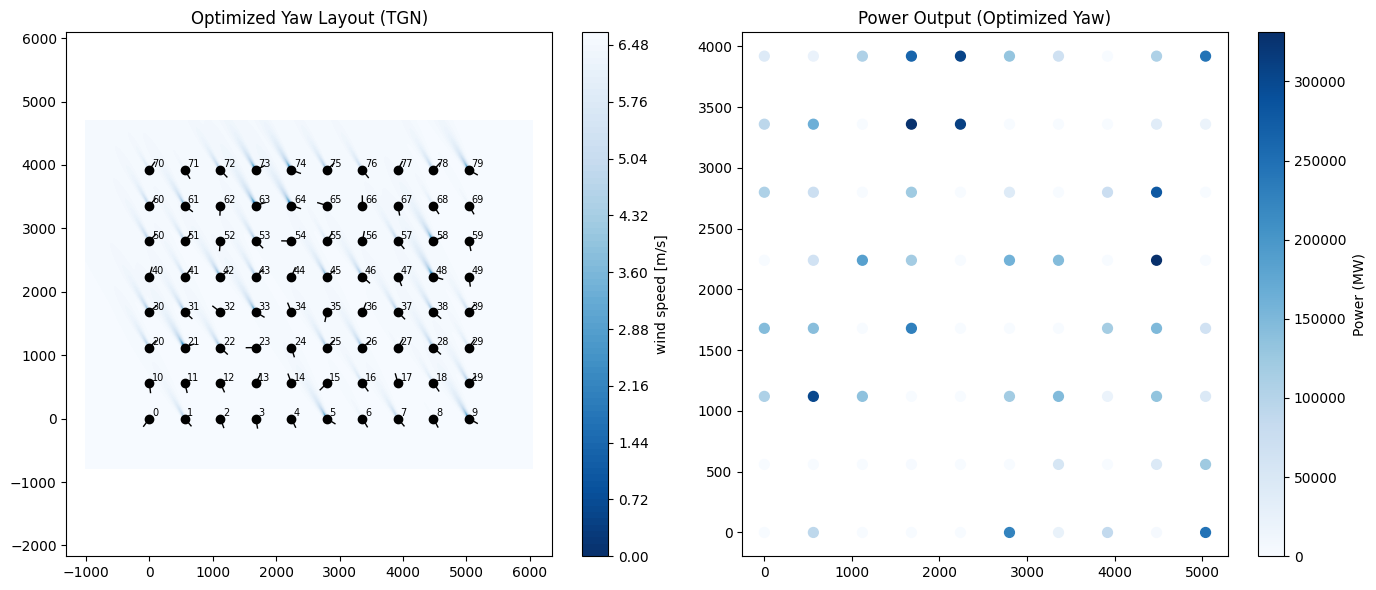

✅ FINAL Optimized Power Output (PyWake): 6.72 MW


In [45]:
# Load trained optimizer
yaw_optimizer = TGNYawOptimizer(
    node_in_dim=4,
    node_hidden_dim=32,
    gru_hidden_dim=64,
    num_turbines=num_turbines
).to(device)
yaw_optimizer.load_state_dict(torch.load("tgn_yaw_optimizer.pth"))
yaw_optimizer.eval()

# Ensure surrogate is in eval mode
surrogate.eval()

# Pick the latest available wind sequence (can replace this with new FNO+PINN wind prediction later)
new_sequence = temporal_sequences[-1]  # You can also loop over all test sequences if needed

with torch.no_grad():
    predicted_yaws = yaw_optimizer([new_sequence])  # keep inside list for batch dim
    predicted_yaws = predicted_yaws.squeeze(0).cpu().numpy()  # shape: [num_turbines]

# Simulate optimized yaw angles using PyWake with real flow model
site = UniformSite(p_wd=[1], ti=0.1)
site.default_wd = np.mean(wind_direction[-1].numpy())  # timestep 45 wind dir
site.default_ws = np.mean(wind_speed[-1].numpy())      # timestep 45 wind speed

wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())
sim_res = wake_model(turbine_x.numpy(), turbine_y.numpy(), yaw=predicted_yaws)

# Plot optimized yaw layout and power output
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sim_res.flow_map().plot_wake_map(ax=axs[0])
axs[0].scatter(turbine_x, turbine_y, color='black', zorder=3)

yaw_rad = np.deg2rad(predicted_yaws)
for xi, yi, yaw in zip(turbine_x, turbine_y, yaw_rad):
    axs[0].plot([xi, xi + 150 * np.cos(yaw)], [yi, yi + 150 * np.sin(yaw)], color='black', linewidth=1)

axs[0].set_title("Optimized Yaw Layout (TGN)")

power_output = sim_res.Power.values.flatten()
scatter = axs[1].scatter(turbine_x, turbine_y, c=power_output, cmap='Blues', s=50)
axs[1].set_title("Power Output (Optimized Yaw)")
fig.colorbar(scatter, ax=axs[1], label='Power (MW)')

plt.tight_layout()
plt.show()

# Calculate total power output after optimization
total_power_MW = np.sum(sim_res.Power.values) / 1e6
print(f"✅ FINAL Optimized Power Output (PyWake): {total_power_MW:.2f} MW")

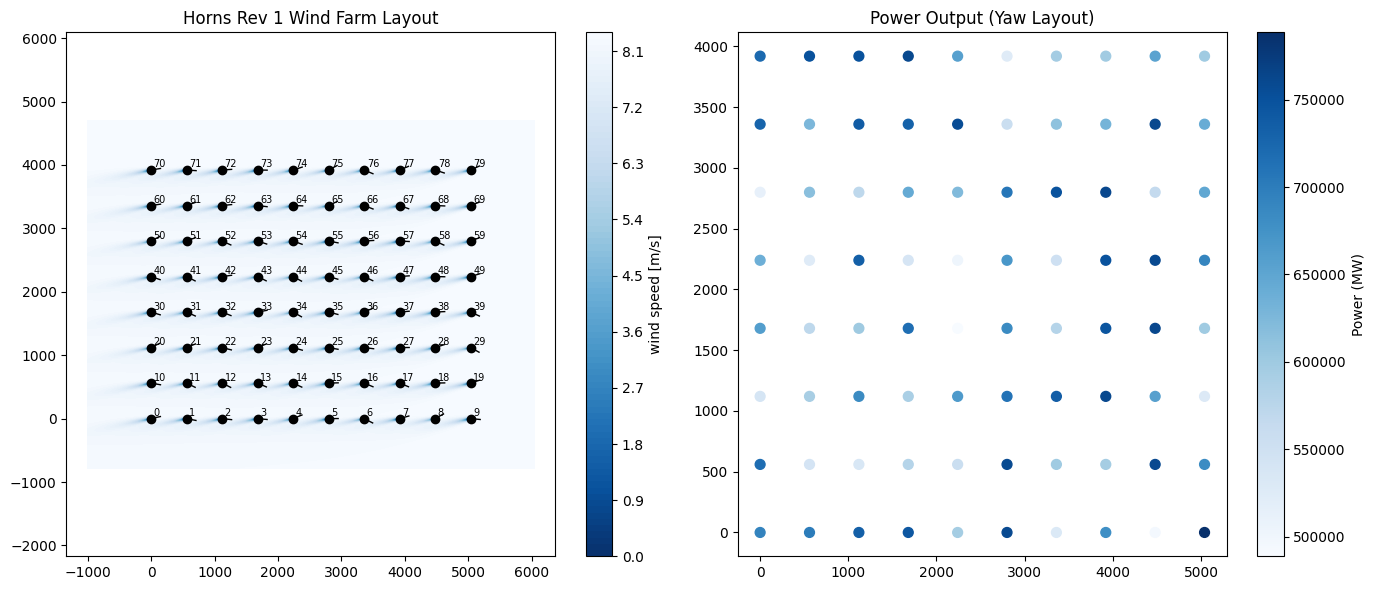

Total Power Output (with random yaw): 52.09 MW


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.hornsrev1 import V80
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.superposition_models import SquaredSum
from py_wake.site import UniformSite

# ---------- Load Fixed Layout ----------
layout = np.load('horns_rev_layout.npz')
turbine_x = layout['turbine_x']
turbine_y = layout['turbine_y']

# ---------- Inject denormalized wind ----------
predicted_ws = np.mean(wind_speed[0].numpy())
predicted_wd = np.mean(wind_direction[0].numpy())

# ---------- Random yaw angles ----------
yaw_angles = np.random.uniform(-30, 30, len(turbine_x))  # yaw in degrees

# ---------- Wake Simulation ----------
site = UniformSite(p_wd=[1], ti=0.1)
site.default_wd = np.array([predicted_wd])
site.default_ws = np.array([predicted_ws])

wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())
sim_res = wake_model(turbine_x, turbine_y, yaw=yaw_angles)

# ---------- Plot ----------
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Wake map
sim_res.flow_map().plot_wake_map(ax=axs[0])
axs[0].scatter(turbine_x, turbine_y, color='black', zorder=3)

# Black yaw lines like "ticks"
yaw_rad = np.deg2rad(yaw_angles)
for xi, yi, yaw in zip(turbine_x, turbine_y, yaw_rad):
    axs[0].plot([xi, xi + 150 * np.cos(yaw)], [yi, yi + 150 * np.sin(yaw)], color='black', linewidth=1)

axs[0].set_title("Horns Rev 1 Wind Farm Layout")

# Power plot
power_output = sim_res.Power.values.flatten()
scatter = axs[1].scatter(turbine_x, turbine_y, c=power_output, cmap='Blues', s=50)
axs[1].set_title("Power Output (Yaw Layout)")
fig.colorbar(scatter, ax=axs[1], label='Power (MW)')

plt.tight_layout()
plt.show()

# ---------- Total Power ----------
total_power_MW = np.sum(sim_res.Power.values) / 1e6
print(f"Total Power Output (with random yaw): {total_power_MW:.2f} MW")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PowerSurrogateNet(nn.Module):
    def __init__(self, num_turbines, hidden_dim=128):
        super(PowerSurrogateNet, self).__init__()
        self.fc1 = nn.Linear(num_turbines * 5, hidden_dim)  # [yaw, ws, wd, x, y] per turbine
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Predict total power

    def forward(self, yaw_angles, ws, wd, turbine_x, turbine_y):
        """
        yaw_angles: [batch_size, num_turbines]
        ws: [batch_size, 1]
        wd: [batch_size, 1]
        turbine_x, turbine_y: [num_turbines] (constant layout)

        Output: total power for the wind farm
        """
        batch_size = yaw_angles.shape[0]
        num_turbines = yaw_angles.shape[1]

        # Repeat static turbine layout for batch
        x = turbine_x.unsqueeze(0).repeat(batch_size, 1)
        y = turbine_y.unsqueeze(0).repeat(batch_size, 1)

        # Expand ws and wd to match turbines
        ws_exp = ws.repeat(1, num_turbines)
        wd_exp = wd.repeat(1, num_turbines)

        # Stack features: [yaw, ws, wd, x, y] per turbine
        features = torch.stack([yaw_angles, ws_exp, wd_exp, x, y], dim=2)  # shape: [batch_size, num_turbines, 5]
        features = features.view(batch_size, -1)  # flatten per turbine

        # Forward pass
        h = F.relu(self.fc1(features))
        h = F.relu(self.fc2(h))
        power = self.fc3(h)  # shape: [batch_size, 1]
        return power.squeeze(1)

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
from py_wake.examples.data.hornsrev1 import V80
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.superposition_models import SquaredSum
from py_wake.site import UniformSite

# ---------- Load Horns Rev 1 layout ----------
layout = np.load('horns_rev_layout.npz')
turbine_x = torch.tensor(layout['turbine_x'], dtype=torch.float32)
turbine_y = torch.tensor(layout['turbine_y'], dtype=torch.float32)
num_turbines = len(turbine_x)

# ---------- Prepare storage ----------
features_list = []
power_list = []

# ---------- PyWake settings ----------
site = UniformSite(p_wd=[1], ti=0.1)
wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())

# ---------- Dataset loop ----------
n_samples = 5000  # you can adjust for more samples
print("⏳ Generating dataset with PyWake...")

for _ in tqdm(range(n_samples)):
    # Random wind conditions + yaw
    ws = np.random.uniform(5, 15)  # wind speed [m/s]
    wd = np.random.uniform(0, 360)  # wind direction [deg]
    yaw = np.random.uniform(-30, 30, num_turbines)  # random yaw angles

    # Simulate power output with PyWake
    site.default_wd = np.array([wd])
    site.default_ws = np.array([ws])
    sim_res = wake_model(turbine_x.numpy(), turbine_y.numpy(), yaw=yaw)
    total_power = np.sum(sim_res.Power.values) / 1e6  # MW

    # Store as feature-target pair
    yaw_t = torch.tensor(yaw, dtype=torch.float32)
    ws_t = torch.full((num_turbines,), ws)
    wd_t = torch.full((num_turbines,), wd)
    feat = torch.stack([yaw_t, ws_t, wd_t, turbine_x, turbine_y], dim=1)  # [num_turbines, 5]

    features_list.append(feat)  # store [num_turbines, 5]
    power_list.append(torch.tensor(total_power, dtype=torch.float32))

# ---------- Save dataset ----------
torch.save({'features': features_list, 'powers': power_list}, 'surrogate_dataset.pt')
print("✅ Dataset saved as 'surrogate_dataset.pt'")

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from py_wake.examples.data.hornsrev1 import V80
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.superposition_models import SquaredSum
from py_wake.site import UniformSite

class SurrogateDataset(Dataset):
    def __init__(self, num_samples, num_turbines):
        self.num_samples = num_samples
        self.num_turbines = num_turbines

        self.ws_range = (3, 25)    # m/s
        self.wd_range = (0, 360)   # degrees
        self.yaw_range = (-30, 30) # degrees

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Random yaw angles per turbine
        yaw = np.random.uniform(*self.yaw_range, self.num_turbines)
        ws = np.random.uniform(*self.ws_range)
        wd = np.random.uniform(*self.wd_range)

        return torch.tensor(yaw, dtype=torch.float32), torch.tensor(ws, dtype=torch.float32), torch.tensor(wd, dtype=torch.float32)

# Turbine layout
layout = np.load('horns_rev_layout.npz')
turbine_x = torch.tensor(layout['turbine_x'], dtype=torch.float32)
turbine_y = torch.tensor(layout['turbine_y'], dtype=torch.float32)
num_turbines = len(turbine_x)

# PyWake Setup (static)
site = UniformSite(p_wd=[1], ti=0.1)
wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())

# Create Dataset
train_dataset = SurrogateDataset(num_samples=1000, num_turbines=num_turbines)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Initialize Surrogate model
surrogate = PowerSurrogateNet(num_turbines=num_turbines).to(device)
optimizer = torch.optim.Adam(surrogate.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

# Train loop
for epoch in range(50):
    surrogate.train()
    total_loss = 0.0

    for yaw, ws, wd in train_loader:
        yaw = yaw.to(device)
        ws = ws.to(device).unsqueeze(1)
        wd = wd.to(device).unsqueeze(1)

        # PyWake ground truth power
        batch_power = []
        for i in range(len(yaw)):
            sim_res = wake_model(
                turbine_x.numpy(),
                turbine_y.numpy(),
                ws=ws[i].item(),
                wd=wd[i].item(),
                yaw=yaw[i].cpu().numpy()
            )
            power = np.sum(sim_res.Power.values) / 1e6
            batch_power.append(power)

        power_gt = torch.tensor(batch_power, dtype=torch.float32).to(device)

        # Predict power with surrogate
        power_pred = surrogate(yaw, ws, wd, turbine_x.to(device), turbine_y.to(device))

        loss = criterion(power_pred, power_gt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} - Surrogate Train Loss: {total_loss / len(train_loader):.4f}")

torch.save(surrogate.state_dict(), "power_surrogate.pth")
print("✅ PowerSurrogateNet trained and saved.")

In [ ]:
# Load your FNO + PINN wind predictions here (assuming 45 timesteps already extracted)
# wind_speed, wind_direction = ... (already computed earlier)

# Reload layout and models
layout = np.load('horns_rev_layout.npz')
turbine_x = torch.tensor(layout['turbine_x'], dtype=torch.float32)
turbine_y = torch.tensor(layout['turbine_y'], dtype=torch.float32)
num_turbines = len(turbine_x)

# Load trained surrogate model
surrogate = PowerSurrogateNet(num_turbines=num_turbines).to(device)
surrogate.load_state_dict(torch.load("power_surrogate.pth"))
surrogate.eval()

# Prepare temporal sequences (same as before)
temporal_sequences = generate_dynamic_dataset(window_size=5)

train_dataset = TGNDataset(temporal_sequences)
train_loader = TorchLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: x)

# Optimizer model (TGN)
yaw_optimizer = TGNYawOptimizer(
    node_in_dim=4,
    node_hidden_dim=32,
    gru_hidden_dim=64,
    num_turbines=num_turbines
).to(device)

optimizer = torch.optim.AdamW(yaw_optimizer.parameters(), lr=0.001, weight_decay=1e-4)

# POWER-BASED TRAINING LOOP
for epoch in range(60):
    yaw_optimizer.train()
    total_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        sequences = batch

        pred_yaws = yaw_optimizer(sequences)  # shape: [batch_size, num_turbines]

        # Get wind input from the latest timestep of each sequence
        ws_list, wd_list = [], []
        for i in range(len(pred_yaws)):
            wind_input = sequences[i][-1]  # latest timestep graph
            ws = wind_input.x[0, 2].item()
            wd = wind_input.x[0, 3].item()
            ws_list.append(ws)
            wd_list.append(wd)

        ws_tensor = torch.tensor(ws_list, dtype=torch.float32, device=device).unsqueeze(1)
        wd_tensor = torch.tensor(wd_list, dtype=torch.float32, device=device).unsqueeze(1)

        # Predict power with surrogate model
        power_pred = surrogate(pred_yaws, ws_tensor, wd_tensor, turbine_x.to(device), turbine_y.to(device))

        # Loss: maximize surrogate power
        loss = -torch.mean(power_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d}: Train Loss = {total_loss / len(train_loader):.4f} (power maximization)")

torch.save(yaw_optimizer.state_dict(), "tgn_yaw_optimizer.pth")
print("✅ TGN yaw optimizer trained!")

In [ ]:
# ---------- Load trained models ----------
yaw_optimizer = TGNYawOptimizer(
    node_in_dim=4,
    node_hidden_dim=32,
    gru_hidden_dim=64,
    num_turbines=num_turbines
).to(device)
yaw_optimizer.load_state_dict(torch.load("tgn_yaw_optimizer.pth"))
yaw_optimizer.eval()

surrogate.eval()  # keep surrogate for reference if needed

# ---------- Inference on latest wind forecast ----------
# Use your latest FNO + PINN wind speed and direction
new_sequence = temporal_sequences[-1]  # Grab latest temporal sequence from dataset

with torch.no_grad():
    predicted_yaws = yaw_optimizer([new_sequence])  # Pass as a list for batch dim
    predicted_yaws = predicted_yaws.squeeze(0).cpu().numpy()

# ---------- Real PyWake simulation with optimized yaw ----------
site = UniformSite(p_wd=[1], ti=0.1)
site.default_wd = np.mean(wind_direction[-1].numpy())  # use timestep 45 wind forecast
site.default_ws = np.mean(wind_speed[-1].numpy())

wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())
sim_res = wake_model(turbine_x.numpy(), turbine_y.numpy(), yaw=predicted_yaws)

# ---------- Plot ----------
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sim_res.flow_map().plot_wake_map(ax=axs[0])
axs[0].scatter(turbine_x, turbine_y, color='black', zorder=3)

yaw_rad = np.deg2rad(predicted_yaws)
for xi, yi, yaw in zip(turbine_x, turbine_y, yaw_rad):
    axs[0].plot([xi, xi + 150 * np.cos(yaw)], [yi, yi + 150 * np.sin(yaw)], color='black', linewidth=1)

axs[0].set_title("Optimized Yaw Layout (TGN)")

power_output = sim_res.Power.values.flatten()
scatter = axs[1].scatter(turbine_x, turbine_y, c=power_output, cmap='Blues', s=50)
axs[1].set_title("Power Output (TGN Optimized)")
fig.colorbar(scatter, ax=axs[1], label='Power (MW)')

plt.tight_layout()
plt.show()

# ---------- Total Power ----------
total_power_MW = np.sum(sim_res.Power.values) / 1e6
print(f"✅ FINAL Optimized Power Output (PyWake): {total_power_MW:.2f} MW")

In [12]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [102]:
# import torch
# import numpy as np
# from torch_geometric.data import Data

# # Load fixed turbine layout
# layout = np.load('horns_rev_layout.npz')
# turbine_x = layout['turbine_x']
# turbine_y = layout['turbine_y']

# # Ground truth yaw angles from your pywake simulation (static for now)
# fixed_yaw_angles = yaw_angles.copy()

# # def generate_dataset_all_timesteps():
# #     dataset = []

# #     # Loop over ALL 45 timesteps (0-44)
# #     for t in range(45):
# #         # Inject denormalized wind speed and wind direction for timestep t
# #         ws_map = wind_speed[t].numpy()   # shape (H, W)
# #         wd_map = wind_direction[t].numpy()

# #         # You could choose interpolation, but for now take the mean as a simple dynamic input
# #         ws = np.mean(ws_map)
# #         wd = np.mean(wd_map)

# #         # Create node features: [x, y, ws, wd] for each turbine
# #         node_features = np.stack([
# #             turbine_x, turbine_y,
# #             np.full_like(turbine_x, ws),
# #             np.full_like(turbine_x, wd)
# #         ], axis=1)  # shape (n_turbines, 4)

# #         # Create a fully connected graph (all turbines can influence each other)
# #         edge_index = torch.combinations(torch.arange(len(turbine_x)), r=2).t().contiguous()
# #         edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # make it bidirectional

# #         # Save sample as graph data
# #         data = Data(
# #             x=torch.tensor(node_features, dtype=torch.float32),
# #             y=torch.tensor(fixed_yaw_angles, dtype=torch.float32),  # Ground truth yaw (static across timesteps)
# #             edge_index=edge_index
# #         )
# #         dataset.append(data)

# #     return dataset

# def generate_temporal_graphs(window_size=5):
#     dataset = []
#     graphs = []

#     # Step 1: create single timestep graphs like you're doing
#     for t in range(45):
#         ws_map = wind_speed[t].numpy()
#         wd_map = wind_direction[t].numpy()
#         ws = np.mean(ws_map)
#         wd = np.mean(wd_map)

#         node_features = np.stack([
#             turbine_x, turbine_y,
#             np.full_like(turbine_x, ws),
#             np.full_like(turbine_x, wd),
#             np.full_like(turbine_x, 0.0)  # Placeholder for yaw_t (for now)
#         ], axis=1)  # shape: (n_turbines, 5)

#         edge_index = torch.combinations(torch.arange(len(turbine_x)), r=2).t().contiguous()
#         edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

#         g = Data(
#             x=torch.tensor(node_features, dtype=torch.float32),
#             edge_index=edge_index,
#             y=torch.tensor(fixed_yaw_angles, dtype=torch.float32),
#             timestep=t
#         )
#         graphs.append(g)

#     # Step 2: Convert into sequences (windowed)
#     for i in range(len(graphs) - window_size):
#         seq = graphs[i:i + window_size]
#         dataset.append(seq)

#     print(f"✅ Generated {len(dataset)} graph sequences of {window_size} timesteps each.")
#     return dataset


# # Create dataset across all 45 timesteps!
# dataset = generate_dataset_all_timesteps()

In [13]:
# import torch
# import numpy as np
# from torch_geometric.data import Data

# # Fixed turbine layout
# layout = np.load('horns_rev_layout.npz')
# turbine_x = layout['turbine_x']
# turbine_y = layout['turbine_y']
# fixed_yaw_angles = yaw_angles.copy()  # From PyWake

# def generate_temporal_dataset(window_size=5):
#     graphs = []

#     for t in range(45):
#         ws = np.mean(wind_speed[t].numpy())
#         wd = np.mean(wind_direction[t].numpy())

#         node_features = np.stack([
#             turbine_x, turbine_y,
#             np.full_like(turbine_x, ws),
#             np.full_like(turbine_x, wd)
#         ], axis=1)

#         edge_index = torch.combinations(torch.arange(len(turbine_x)), r=2).t().contiguous()
#         edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

#         g = Data(
#             x=torch.tensor(node_features, dtype=torch.float32),
#             edge_index=edge_index,
#             y=torch.tensor(fixed_yaw_angles, dtype=torch.float32),
#             timestep=t
#         )
#         graphs.append(g)

#     # Step 2: convert into sequences
#     sequences = []
#     for i in range(len(graphs) - window_size):
#         seq = graphs[i:i + window_size]
#         target = graphs[i + window_size].y
#         sequences.append((seq, target))

#     print(f"✅ Created {len(sequences)} temporal graph sequences!")
#     return sequences

# temporal_sequences = generate_temporal_dataset(window_size=5)

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

✅ Created 40 temporal graph sequences!


In [39]:
import torch
import numpy as np
from torch_geometric.data import Data

layout = np.load('horns_rev_layout.npz')
turbine_x = layout['turbine_x']
turbine_y = layout['turbine_y']

def generate_dynamic_dataset(window_size=5):
    graphs = []

    for t in range(45):
        ws = np.mean(wind_speed[t].numpy())
        wd = np.mean(wind_direction[t].numpy())

        node_features = np.stack([
            turbine_x, turbine_y,
            np.full_like(turbine_x, ws),
            np.full_like(turbine_x, wd)
        ], axis=1)  # [num_turbines, 4]

        edge_index = torch.combinations(torch.arange(len(turbine_x)), r=2).t().contiguous()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

        g = Data(
            x=torch.tensor(node_features, dtype=torch.float32),
            edge_index=edge_index,
            timestep=t  # optional for future use
        )
        graphs.append(g)

    # Create temporal sequences
    sequences = []
    for i in range(len(graphs) - window_size):
        seq = graphs[i:i + window_size]
        sequences.append(seq)  # ⚠️ No targets anymore (pure self-supervised RL-like setup)

    print(f"✅ Created {len(sequences)} temporal graph sequences!")
    return sequences

temporal_sequences = generate_dynamic_dataset(window_size=5)

✅ Created 40 temporal graph sequences!


In [40]:
# class TGNYawPredictor(nn.Module):
#     def __init__(self, node_in_dim=5, node_hidden_dim=32, gru_hidden_dim=64, out_dim=1):
#         super(TGNYawPredictor, self).__init__()

#         self.gnn = GCNConv(node_in_dim, node_hidden_dim)
#         self.gru = nn.GRU(node_hidden_dim, gru_hidden_dim, batch_first=True)

#         # ⚠️ Change here! Make it flexible for multiple turbines.
#         self.yaw_regressor = nn.Sequential(
#             nn.Linear(gru_hidden_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, out_dim)  # out_dim = number of turbines now
#         )

#     def forward(self, batched_sequences):
#         batch_size = len(batched_sequences)
#         seq_len = len(batched_sequences[0])

#         # ✅ New fix - unwrap PyG Batch inside each sequence
#         if isinstance(batched_sequences[0][0], list):
#             batched_sequences = [[g[0] for g in seq] for seq in batched_sequences]

#         num_turbines = batched_sequences[0][0].x.size(0)

#         # Step 1: Encode each timestep with GNN
#         graph_embeddings = []
#         for t in range(seq_len):
#             x_t_list = []
#             edge_index_list = []
#             batch_idx_list = []

#             for b in range(batch_size):
#                 x_t_list.append(batched_sequences[b][t].x)
#                 edge_index_list.append(batched_sequences[b][t].edge_index)
#                 batch_idx_list.append(torch.full((num_turbines,), b, dtype=torch.long))

#             x_t = torch.cat(x_t_list, dim=0)
#             edge_index = torch.cat([ei + i * num_turbines for i, ei in enumerate(edge_index_list)], dim=1)
#             batch_idx = torch.cat(batch_idx_list, dim=0)

#             h_t = F.relu(self.gnn(x_t, edge_index))

#             # Keep node-level features instead of pooling
#             h_t_split = torch.stack(torch.split(h_t, num_turbines, dim=0))  # [batch_size, num_turbines, hidden_dim]
#             graph_embeddings.append(h_t_split.unsqueeze(1))  # [batch_size, 1, num_turbines, hidden_dim]

#         # Step 2: GRU (per turbine)
#         node_sequence = torch.cat(graph_embeddings, dim=1)  # [batch_size, seq_len, num_turbines, hidden_dim]
#         node_sequence = node_sequence.permute(0, 2, 1, 3)   # [batch_size, num_turbines, seq_len, hidden_dim]

#         yaw_preds = []
#         for i in range(num_turbines):
#             out, _ = self.gru(node_sequence[:, i, :, :])  # [batch_size, seq_len, gru_hidden_dim]
#             yaw = self.yaw_regressor(out[:, -1, :])  # Take final timestep
#             yaw_preds.append(yaw)

#         yaw_preds = torch.cat(yaw_preds, dim=1)  # [batch_size, num_turbines]
#         return yaw_preds

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, global_mean_pool

# class TGNYawPredictor(nn.Module):
#     def __init__(self, node_in_dim=5, node_hidden_dim=32, gru_hidden_dim=64, num_turbines=40):
#         super(TGNYawPredictor, self).__init__()

#         # GNN Encoder
#         self.gnn = GCNConv(node_in_dim, node_hidden_dim)

#         # GRU Processor (takes in graph-level embeddings over time)
#         self.gru = nn.GRU(node_hidden_dim, gru_hidden_dim, batch_first=True)

#         # Decoder to predict yaw angle for each turbine (output_dim = num_turbines)
#         self.yaw_regressor = nn.Sequential(
#             nn.Linear(gru_hidden_dim, gru_hidden_dim),
#             nn.ReLU(),
#             nn.Linear(gru_hidden_dim, num_turbines)  # Predict yaw per turbine
#         )

#     def forward(self, batched_sequences):

#     # ✅ Unpack seq & target pairs
#         sequences = batched_sequences  # we only use seq here
#         batch_size = len(sequences)
#         seq_len = len(sequences[0])  # assuming all sequences same length

#         # Dynamic turbine count based on input graphs
#         num_turbines = sequences[0][0].x.size(0)  # first graph, first timestep

#         graph_embeddings = []

#         for t in range(seq_len):
#             x_t_list = []
#             edge_index_list = []
#             batch_idx_list = []

#             for b in range(batch_size):
#                 graph = sequences[b][t]  # grab graph for timestep t from batch item b
#                 x_t_list.append(graph.x)
#                 edge_index_list.append(graph.edge_index)
#                 batch_idx_list.append(torch.full((num_turbines,), b, dtype=torch.long, device=graph.x.device))

#             x_t = torch.cat(x_t_list, dim=0)  # [batch_size * num_turbines, node_in_dim]
#             edge_index = torch.cat([ei + i * num_turbines for i, ei in enumerate(edge_index_list)], dim=1)
#             batch_idx = torch.cat(batch_idx_list, dim=0)

#             # GNN
#             h_t = F.relu(self.gnn(x_t, edge_index))

#             # Global pooling (graph-level)
#             graph_h = global_mean_pool(h_t, batch_idx)  # [batch_size, node_hidden_dim]
#             graph_embeddings.append(graph_h.unsqueeze(1))  # [batch_size, 1, node_hidden_dim]

#         # GRU
#         sequence = torch.cat(graph_embeddings, dim=1)  # [batch_size, seq_len, node_hidden_dim]
#         gru_out, _ = self.gru(sequence)  # [batch_size, seq_len, gru_hidden_dim]

#         # Decoder from last timestep
#         last_hidden = gru_out[:, -1, :]  # [batch_size, gru_hidden_dim]
#         predicted_yaws = self.yaw_regressor(last_hidden)  # [batch_size, num_turbines]

#         return predicted_yaws





In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class TGNYawOptimizer(nn.Module):
    def __init__(self, node_in_dim=4, node_hidden_dim=32, gru_hidden_dim=64, num_turbines=40):
        super(TGNYawOptimizer, self).__init__()

        # GNN Encoder for each timestep graph
        self.gnn = GCNConv(node_in_dim, node_hidden_dim)

        # GRU temporal processor
        self.gru = nn.GRU(node_hidden_dim, gru_hidden_dim, batch_first=True)

        # Output: directly predict yaw angles (continuous)
        self.yaw_head = nn.Sequential(
            nn.Linear(gru_hidden_dim, gru_hidden_dim),
            nn.ReLU(),
            nn.Linear(gru_hidden_dim, num_turbines)
        )

    def forward(self, sequences):
        batch_size = len(sequences)
        seq_len = len(sequences[0])  # timesteps

        num_turbines = sequences[0][0].x.size(0)  # consistent across samples

        graph_embeddings = []

        for t in range(seq_len):
            x_t_list = []
            edge_index_list = []
            batch_idx_list = []

            for b in range(batch_size):
                graph = sequences[b][t]
                x_t_list.append(graph.x)
                edge_index_list.append(graph.edge_index)
                batch_idx_list.append(torch.full((num_turbines,), b, dtype=torch.long, device=graph.x.device))

            x_t = torch.cat(x_t_list, dim=0)
            edge_index = torch.cat([ei + i * num_turbines for i, ei in enumerate(edge_index_list)], dim=1)
            batch_idx = torch.cat(batch_idx_list, dim=0)

            h_t = F.relu(self.gnn(x_t, edge_index))
            graph_h = global_mean_pool(h_t, batch_idx)
            graph_embeddings.append(graph_h.unsqueeze(1))  # shape: [batch_size, 1, node_hidden_dim]

        sequence = torch.cat(graph_embeddings, dim=1)  # [batch_size, seq_len, node_hidden_dim]
        gru_out, _ = self.gru(sequence)  # [batch_size, seq_len, gru_hidden_dim]

        last_hidden = gru_out[:, -1, :]  # [batch_size, gru_hidden_dim]
        predicted_yaws = self.yaw_head(last_hidden)  # [batch_size, num_turbines]

        return predicted_yaws


In [42]:
# temporal_sequences = generate_temporal_dataset(window_size=5)

# # 🟩 2. Dataset wrapper class (add this right here)
# from torch.utils.data import Dataset

# class TGNDataset(Dataset):
#     def __init__(self, sequences):
#         self.sequences = sequences  # list of (seq, target) tuples

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         return self.sequences[idx]

# # 🟩 3. Then split dataset
# train_dataset = temporal_sequences[:int(0.8 * len(temporal_sequences))]
# test_dataset = temporal_sequences[int(0.8 * len(temporal_sequences)):]

# train_dataset = TGNDataset(train_dataset)
# test_dataset = TGNDataset(test_dataset)

# from torch_geometric.loader import DataLoader


# # ⚠️ Since each item is a sequence of graphs, we use normal PyTorch DataLoader
# from torch.utils.data import DataLoader as TorchLoader

# batch_size = 4

# train_loader = TorchLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
# test_loader = TorchLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

from torch.utils.data import Dataset, DataLoader as TorchLoader

class TGNDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences  # just temporal graph sequences now

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

# Split train/test
train_sequences = temporal_sequences[:int(0.8 * len(temporal_sequences))]
test_sequences = temporal_sequences[int(0.8 * len(temporal_sequences)):]

train_dataset = TGNDataset(train_sequences)
test_dataset = TGNDataset(test_sequences)

# DataLoader using collate_fn to keep batches as "lists of sequences"
batch_size = 4

train_loader = TorchLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
test_loader = TorchLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)


# ✅ Optimizer & Scheduler
import torch.optim as optim

model = TGNYawPredictor(
    node_in_dim=4,   # Since your node features are [x, y, ws, wd]
    node_hidden_dim=32,
    gru_hidden_dim=64,
    num_turbines=len(turbine_x)
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=120,
    pct_start=0.3,
    final_div_factor=1e4
)

# criterion = nn.MSELoss()


In [43]:
import os
import torch.nn as nn

# def train_one_epoch(model, loader, optimizer, scheduler):
#     model.train()
#     total_loss = 0.0

#     for batch in loader:
#         optimizer.zero_grad()
#         sequences, _ = zip(*batch)  # don't need static yaw target anymore

#         predicted_yaws = model(sequences)

#         # 🚩 PyWake power simulation (differentiable blocked, so detach first)
#         batch_power = []
#         for i in range(len(predicted_yaws)):
#             yaw_i = predicted_yaws[i].detach().cpu().numpy()
#             wind_input = sequences[i][-1]
#             ws = wind_input.x[0, 2].item()
#             wd = wind_input.x[0, 3].item()
#             sim_res = wake_model(turbine_x, turbine_y, ws=ws, wd=wd, yaw=yaw_i)
#             power = np.sum(sim_res.Power.values) / 1e6
#             batch_power.append(power)

#         avg_batch_power = sum(batch_power) / len(batch_power)
#         # 🚩 Power-based loss
#         loss = 1 / (avg_batch_power + 1e-6)
#         loss = torch.tensor(loss, requires_grad=True, device=device)  # fix here!
#         loss.backward()
#         optimizer.step()
#         if scheduler:
#             scheduler.step()
#         total_loss += loss.item()

#     return total_loss / len(loader)


# # def test_one_epoch(model, loader, criterion):
# #     model.eval()
# #     total_loss = 0.0
# #     with torch.no_grad():
# #         for batch in loader:
# #             sequences, targets = zip(*batch)  # Unpack both seq and target here

# #             pred = model(sequences)  # only pass sequences
# #             targets = torch.stack(targets).to(device)
# #             loss = criterion(pred, targets)
# #             total_loss += loss.item()
# #     return total_loss / len(loader)
# def test_one_epoch(model, loader):
#     model.eval()
#     total_power = 0.0

#     with torch.no_grad():
#         for batch in loader:
#             sequences, _ = zip(*batch)  # we don't need ground truth yaws anymore

#             pred = model(sequences)

#             # PyWake power calculation
#             batch_power = []
#             for i in range(len(pred)):
#                 yaw_i = pred[i].detach().cpu().numpy()
#                 wind_input = sequences[i][-1]
#                 ws = wind_input.x[0, 2].item()
#                 wd = wind_input.x[0, 3].item()

#                 sim_res = wake_model(
#                     turbine_x,
#                     turbine_y,
#                     ws=ws,
#                     wd=wd,
#                     yaw=yaw_i
#                 )
#                 power = np.sum(sim_res.Power.values) / 1e6
#                 batch_power.append(power)

#             total_power += sum(batch_power)

#     avg_power = total_power / len(loader.dataset)
#     return avg_power  # return only power now



# def train(model, optimizer, loader_train, loader_test, scheduler=None, epochs=120, save_every=10):
#     criterion = nn.MSELoss()
#     model = model.to(device)
#     best_loss = float('inf')

#     for epoch in range(epochs):
#         train_loss = train_one_epoch(model, loader_train, optimizer, scheduler=scheduler)
#         test_loss = test_one_epoch(model, loader_test)

#         print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss} | Test Loss = {test_loss:}")

#         # Save model every 10th epoch
#         if (epoch + 1) % save_every == 0:
#             torch.save(model.state_dict(), f"yaw_gnn_epoch_{epoch+1}.pth")
#             print(f"Saved model checkpoint at epoch {epoch+1}")

#         # # Save best model
#         # if test_loss < best_loss:
#         #     best_loss = test_loss
#         #     torch.save(model.state_dict(), "yaw_gnn_best.pth")
#         #     print(f"Best model updated at epoch {epoch+1} with test loss: {best_loss}")

#     print("🏁 Training finished.")


In [46]:
def train_one_epoch(model, loader, optimizer, scheduler=None):
    model.train()
    total_loss = 0.0

    for batch in loader:
        optimizer.zero_grad()
        sequences = batch  # Ignore old targets (static yaw angles)
        predicted_yaws = model(sequences)

        # PyWake power-based feedback
        batch_power = []
        for i in range(len(predicted_yaws)):
            yaw_i = predicted_yaws[i].detach().cpu().numpy()
            wind_input = sequences[i][-1]
            ws = wind_input.x[0, 2].item()
            wd = wind_input.x[0, 3].item()

            sim_res = wake_model(turbine_x, turbine_y, ws=ws, wd=wd, yaw=yaw_i)
            power = np.sum(sim_res.Power.values) / 1e6  # MW
            batch_power.append(power)

        avg_batch_power = sum(batch_power) / len(batch_power)
        # Power-maximization loss
        loss = torch.tensor(1 / (avg_batch_power + 1e-6), requires_grad=True, device=device)

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def test_one_epoch(model, loader):
    model.eval()
    total_power = 0.0

    with torch.no_grad():
        for batch in loader:
            sequences = batch
            pred = model(sequences)

            batch_power = []
            for i in range(len(pred)):
                yaw_i = pred[i].detach().cpu().numpy()
                wind_input = sequences[i][-1]
                ws = wind_input.x[0, 2].item()
                wd = wind_input.x[0, 3].item()

                sim_res = wake_model(turbine_x, turbine_y, ws=ws, wd=wd, yaw=yaw_i)
                power = np.sum(sim_res.Power.values) / 1e6
                batch_power.append(power)

            total_power += sum(batch_power)

    avg_power = total_power / len(loader.dataset)
    return avg_power

def train(model, optimizer, loader_train, loader_test, scheduler=None, epochs=120, save_every=10):
    model = model.to(device)
    best_power = -float('inf')

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, loader_train, optimizer, scheduler=scheduler)
        test_power = test_one_epoch(model, loader_test)

        print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss} | Avg Test Power = {test_power} MW")

        # Save model every `save_every` epochs
        if (epoch + 1) % save_every == 0:
            torch.save(model.state_dict(), f"tgn_poweropt_epoch_{epoch+1}.pth")
            print(f"💾 Saved model checkpoint at epoch {epoch+1}")

    print("🏁 Training finished.")


In [47]:
# Launch Training
train(
    model=model,
    optimizer=optimizer,
    loader_train=train_loader,
    loader_test=test_loader,
    scheduler=scheduler,
    epochs=120,
    save_every=10
)

Epoch 01: Train Loss = 0.037290203972220395 | Avg Test Power = 44.99721663622524 MW
Epoch 02: Train Loss = 0.04189069712735323 | Avg Test Power = 44.99721663622524 MW
Epoch 03: Train Loss = 0.03789276040863368 | Avg Test Power = 44.99721663622524 MW
Epoch 04: Train Loss = 0.041809393848751444 | Avg Test Power = 44.99721663622524 MW
Epoch 05: Train Loss = 0.03804142414416809 | Avg Test Power = 44.99721663622524 MW
Epoch 06: Train Loss = 0.039356030721572864 | Avg Test Power = 44.99721663622524 MW
Epoch 07: Train Loss = 0.03287595493742023 | Avg Test Power = 44.99721663622524 MW
Epoch 08: Train Loss = 0.03801145369855304 | Avg Test Power = 44.99721663622524 MW
Epoch 09: Train Loss = 0.04041603587061508 | Avg Test Power = 44.99721663622524 MW
Epoch 10: Train Loss = 0.03890279090064512 | Avg Test Power = 44.99721663622524 MW
💾 Saved model checkpoint at epoch 10
Epoch 11: Train Loss = 0.04998200945329557 | Avg Test Power = 44.99721663622524 MW
Epoch 12: Train Loss = 0.03578261878465136 | Av

KeyboardInterrupt: 

In [ ]:
# Example: pick the last available test sequence (or from new wind predictions)
new_sequence = test_dataset[-1][0]  # The [0] extracts the sequence (not target)

In [ ]:
model.eval()
with torch.no_grad():
    predicted_yaw_angles = model([new_sequence])  # keep inside list for batch dim
    predicted_yaw_angles = predicted_yaw_angles.squeeze(0).cpu().numpy()  # [num_turbines]

In [ ]:
# Simulate with predicted yaw angles
site = UniformSite(p_wd=[1], ti=0.1)
site.default_wd = np.mean(wind_direction[-1].numpy())  # Last timestep wind
site.default_ws = np.mean(wind_speed[-1].numpy())

wake_model = Bastankhah_PorteAgel_2014(site, V80(), k=0.075, superpositionModel=SquaredSum())
sim_res = wake_model(turbine_x, turbine_y, yaw=predicted_yaw_angles)

# Calculate total power
total_power_MW = np.sum(sim_res.Power.values) / 1e6
print(f"Optimized Power Output: {total_power_MW:.2f} MW")